In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_csv("data/f1_ml_laps_dataset.csv")
print("Raw shape:", df.shape)

# Clean
df = df[(df["lap_time"] > 30) & (df["lap_time"] < 200)]
df = df.dropna(subset=["sector_1_time", "sector_2_time", "sector_3_time"])

df.head()



Raw shape: (23983, 31)


,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,sector_3_time,position,track_status,is_pit_lap,compound,stint,tyre_life,fresh_tyre,speed_mean,speed_max,throttle_mean,brake_mean,rpm_mean,rpm_max,drs_activations,air_temp,track_temp,humidity,wind_speed,wind_dir,pressure
1,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,2,97.974,31.342,42.504,24.128,1,12,False,SOFT,1,5,False,195.407713,298,60.225895,0.203857,9773.179063,12063,363,27.3,31.1,22,0.0,208,1016.7
2,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,3,98.006,31.388,42.469,24.149,1,1,False,SOFT,1,6,False,198.095109,298,62.290761,0.184783,9756.970109,11795,0,27.3,31.2,22,0.6,170,1016.7
3,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,4,97.976,31.271,42.642,24.063,1,1,False,SOFT,1,7,False,195.786842,299,62.092105,0.200000,9723.621053,11960,0,27.2,31.1,22,0.8,236,1016.9
4,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,5,98.035,31.244,42.724,24.067,1,1,False,SOFT,1,8,False,197.120879,301,60.884615,0.206044,9710.263736,11911,0,27.2,31.0,22,1.0,206,1016.7
5,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,6,97.986,31.341,42.632,24.013,1,1,False,SOFT,1,9,False,196.887363,301,60.942308,0.200549,9767.299451,11852,0,27.1,31.0,22,0.6,175,1016.9


In [3]:
tyre_base = df.copy()

# Remove pit laps if available
if "is_pit_lap" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["is_pit_lap"] == 0]

# Remove non-green laps if track_status exists
if "track_status" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["track_status"] == 1]

# Driver pace offset
driver_means = tyre_base.groupby("driver")["lap_time"].mean()
global_mean = tyre_base["lap_time"].mean()
driver_offset_map = (driver_means - global_mean).to_dict()

tyre_base["driver_pace_offset"] = tyre_base["driver"].map(driver_offset_map)
tyre_base["driver_pace_offset"] -= tyre_base["driver_pace_offset"].mean()


# ============================================
# ADD FUEL LOAD ESTIMATE
# ============================================
# Estimate remaining fuel as percentage of race
# Lap 1 = 100% fuel, Last lap = 0% fuel
tyre_base['fuel_load_pct'] = 1 - (
    tyre_base['lap_number'] / 
    tyre_base.groupby('gp_name')['lap_number'].transform('max')
)

print(f"✅ Added fuel_load_pct feature")
print(f"   Lap 1 fuel: {tyre_base['fuel_load_pct'].max():.2f} (100%)")
print(f"   Last lap fuel: {tyre_base['fuel_load_pct'].min():.2f} (0%)")


✅ Added fuel_load_pct feature
   Lap 1 fuel: 0.97 (100%)
   Last lap fuel: 0.00 (0%)


In [4]:
tyre_cat_features = ["gp_name", "compound"]
tyre_base['fuel_load_pct'] = 1 - (tyre_base['lap_number'] / tyre_base.groupby('gp_name')['lap_number'].transform('max'))


tyre_num_features = [
    "tyre_life", "stint",
    "fuel_load_pct",  # ← ADDED: Fuel load estimate to separate fuel effect from tire degradation
    "track_temp", "air_temp", "humidity",
    "wind_speed", "wind_dir", "pressure",
    "driver_pace_offset"
]

tyre_target = "lap_time"

cols_needed = tyre_cat_features + tyre_num_features + [tyre_target]

tyre_df = tyre_base.dropna(subset=cols_needed).copy()
print("Tyre dataset:", tyre_df.shape)

Tyre dataset: (20541, 33)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_t = tyre_df[tyre_cat_features + tyre_num_features]
y_t = tyre_df[tyre_target]

X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42
)

num_t = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_t = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre_tyre = ColumnTransformer([
    ("num", num_t, tyre_num_features),
    ("cat", cat_t, tyre_cat_features)
])

tyre_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

tyre_pipeline = Pipeline([
    ("pre", pre_tyre),
    ("model", tyre_model)
])

print("Training RandomForest model...")
tyre_pipeline.fit(X_t_train, y_t_train)

y_t_pred = tyre_pipeline.predict(X_t_test)

# Calculate metrics
mae = mean_absolute_error(y_t_test, y_t_pred)
mse = mean_squared_error(y_t_test, y_t_pred)
rmse = np.sqrt(mse)  # Calculate RMSE manually
r2 = r2_score(y_t_test, y_t_pred)

print("\n✅ Tire Strategy Model Performance:")
print(f" MAE  : {mae:.4f} seconds")
print(f" RMSE : {rmse:.4f} seconds")
print(f" R²   : {r2:.6f}")
print(f"\n Model: RandomForest with {tyre_model.n_estimators} trees")

Training RandomForest model...

✅ Tire Strategy Model Performance:
 MAE  : 0.4435 seconds
 RMSE : 1.1715 seconds
 R²   : 0.988436

 Model: RandomForest with 300 trees


In [6]:
def get_driver_offset(driver_name):
    return float(driver_offset_map.get(driver_name, 0.0))

def predict_tyre_laptime(
    gp_name, compound, tyre_life, stint,
    fuel_load_pct,  # ← CHANGED: Now uses fuel_load_pct instead of lap_number
    track_temp, air_temp, humidity,
    wind_speed, wind_dir, pressure,
    driver=None
):
    pace = get_driver_offset(driver) if driver else 0.0

    row = {
        "gp_name": gp_name,
        "compound": compound,
        "tyre_life": tyre_life,
        "stint": stint,
        "fuel_load_pct": fuel_load_pct,
        "track_temp": track_temp,
        "air_temp": air_temp,
        "humidity": humidity,
        "wind_speed": wind_speed,
        "wind_dir": wind_dir,
        "pressure": pressure,
        "driver_pace_offset": pace
    }

    return float(tyre_pipeline.predict(pd.DataFrame([row]))[0])


In [7]:
def estimate_pit_loss(df_full, gp_name, driver=None):
    temp = df_full[df_full["gp_name"] == gp_name]

    if driver:
        temp = temp[temp["driver"] == driver]

    if "is_pit_lap" not in temp.columns:
        return 20.0

    pit = temp[temp["is_pit_lap"] == 1]["lap_time"]
    normal = temp[temp["is_pit_lap"] == 0]["lap_time"]

    if pit.empty or normal.empty:
        return 20.0

    return float(np.clip(pit.median() - normal.median(), 10, 35))


In [8]:
def simulate_tyre_strategy(strategy, total_laps, pit_loss, gp_name, weather_dict, driver=None):
    """Simulate entire race with given tire strategy"""
    laps = []
    total_time = 0
    lap_num = 1
    stint_idx = 0

    for compound, stint_len in strategy:
        stint_idx += 1
        for life in range(1, stint_len + 1):
            if lap_num > total_laps:
                break

            # Calculate fuel load percentage for this lap
            fuel_pct = 1 - (lap_num / total_laps)

            lt = predict_tyre_laptime(
                gp_name, compound, life, stint_idx,
                fuel_pct,  # ← ADDED: Pass fuel load
                weather_dict["track_temp"], weather_dict["air_temp"],
                weather_dict["humidity"], weather_dict["wind_speed"],
                weather_dict["wind_dir"], weather_dict["pressure"],
                driver=driver
            )

            total_time += lt
            laps.append({"lap": lap_num, "compound": compound, "lap_time_pred": lt})
            lap_num += 1

        if lap_num <= total_laps:
            total_time += pit_loss

    return total_time, pd.DataFrame(laps)


In [9]:
def possible_stint_lengths(total_laps):
    return list(range(10, min(30, total_laps - 10) + 1))

def generate_strategies_fast(total_laps, compounds):
    lengths = possible_stint_lengths(total_laps)
    strategies = []

    # ---------------------
    # 1-stop (2 stints)
    # ---------------------
    for c1 in compounds:
        for c2 in compounds:
            if c1 == c2:
                continue

            for s1 in lengths:
                s2 = total_laps - s1
                if s2 < 10 or s2 > 30:
                    continue
                strategies.append([(c1, s1), (c2, s2)])

    # ---------------------
    # 2-stop (3 stints)
    # ---------------------
    for c1 in compounds:
        for c2 in compounds:
            for c3 in compounds:
                if len({c1, c2, c3}) < 2:
                    continue

                for s1 in lengths:
                    for s2 in lengths:
                        s3 = total_laps - (s1 + s2)
                        if 10 <= s3 <= 30:
                            strategies.append([(c1, s1), (c2, s2), (c3, s3)])

    return strategies


In [10]:
def find_best_strategies(
    gp_name, total_laps, weather_dict, driver=None, top_k=5
):
    compounds = sorted(df["compound"].unique())
    pit_loss = estimate_pit_loss(df, gp_name, driver)

    strategies = generate_strategies_fast(total_laps, compounds)

    results = []
    for strat in strategies:
        tt, _ = simulate_tyre_strategy(
            strat, total_laps, pit_loss, gp_name, weather_dict, driver,
        )
        results.append({"strategy": strat, "total_time": tt})

    return pd.DataFrame(results).sort_values("total_time").head(top_k)


In [12]:
print("=== Tyre Model: Existing Driver (VER) ===")
ver_time = predict_tyre_laptime(
    gp_name="Bahrain Grand Prix", compound="Medium",
    tyre_life=7, stint=1,
    track_temp=36, air_temp=28, humidity=40,
    wind_speed=3.2, wind_dir=140, pressure=1006,
    fuel_load_pct=45,
    driver="VER"
)
print("Predicted:", ver_time)

=== Tyre Model: Existing Driver (VER) ===
Predicted: 94.61497233577926


In [15]:
print("=== Tyre Model: New Driver (General Model) ===")
new_time = predict_tyre_laptime(
    gp_name="Bahrain Grand Prix", compound="Medium",
    tyre_life=7, stint=1, 
    # tyre_life=7, stint=1, lap_number=7,
    track_temp=36, air_temp=28, humidity=40,
    wind_speed=3.2, wind_dir=140, pressure=1006,
    fuel_load_pct=45,
    driver=None
)
print("Predicted:", new_time)


=== Tyre Model: New Driver (General Model) ===
Predicted: 95.78410611996172


In [16]:
weather = {
    "track_temp": 36,
    "air_temp": 28,
    "humidity": 40,
    "wind_speed": 3.2,
    "wind_dir": 140,
    "pressure": 1006,
}

strategy = [("Medium", 15), ("Hard", 20)]


total, df_strat = simulate_tyre_strategy(
    strategy, total_laps=35, pit_loss=22,
    gp_name="Bahrain Grand Prix",
    weather_dict=weather,
    driver=None
)
print("Total time:", total)
df_strat.head()


Total time: 3350.5989800929956


,lap,compound,lap_time_pred
0,1,Medium,96.056593
1,2,Medium,96.029311
2,3,Medium,96.104428
3,4,Medium,96.200554
4,5,Medium,95.957718


In [18]:
from tqdm import tqdm

weather = {
    "track_temp": 36,
    "air_temp": 28,
    "humidity": 40,
    "wind_speed": 3.2,
    "wind_dir": 140,
    "pressure": 1006,
}

race_laps = 57  # Bahrain

# Only use DRY compounds
dry_compounds = ['HARD', 'MEDIUM', 'SOFT']
pit_loss = estimate_pit_loss(df, "Bahrain Grand Prix")

print(f"🔍 Searching tire strategies for Bahrain GP ({race_laps} laps)")
print(f"   Compounds: {dry_compounds}")
print(f"   Pit stop time: {pit_loss:.1f}s\n")

# Test limited strategies (1-stop only, key stint lengths)
strategies_to_test = []
for c1 in dry_compounds:
    for c2 in dry_compounds:
        if c1 == c2:
            continue
        for s1 in [20, 25, 27, 30, 32]:
            s2 = race_laps - s1
            if 20 <= s2 <= 37:
                strategies_to_test.append([(c1, s1), (c2, s2)])

print(f"Testing {len(strategies_to_test)} strategies...\n")

results = []
for strat in tqdm(strategies_to_test, desc="Simulating"):
    tt, _ = simulate_tyre_strategy(
        strat, race_laps, pit_loss, "Bahrain Grand Prix", weather, driver=None
    )
    results.append({"strategy": str(strat), "total_time": tt})

best = pd.DataFrame(results).sort_values("total_time").head(10)

print(f"\n✅ Top 10 Tire Strategies for Bahrain:\n")
best

🔍 Searching tire strategies for Bahrain GP (57 laps)
   Compounds: ['HARD', 'MEDIUM', 'SOFT']
   Pit stop time: 19.2s

Testing 30 strategies...



Simulating: 100%|██████████| 30/30 [01:56<00:00,  3.88s/it]


✅ Top 10 Tire Strategies for Bahrain:



,strategy,total_time
19,"[('MEDIUM', 32), ('SOFT', 25)]",5448.977988
15,"[('MEDIUM', 20), ('SOFT', 37)]",5449.497388
18,"[('MEDIUM', 30), ('SOFT', 27)]",5449.508219
17,"[('MEDIUM', 27), ('SOFT', 30)]",5449.538866
16,"[('MEDIUM', 25), ('SOFT', 32)]",5449.813860
9,"[('HARD', 32), ('SOFT', 25)]",5450.162125
14,"[('MEDIUM', 32), ('HARD', 25)]",5450.310250
5,"[('HARD', 20), ('SOFT', 37)]",5450.476699
8,"[('HARD', 30), ('SOFT', 27)]",5450.652629
7,"[('HARD', 27), ('SOFT', 30)]",5450.676108


In [19]:
def get_actual_strategy(df, gp_name, driver):
    """Extract actual tire strategy used by driver in race"""
    race_data = df[(df["gp_name"] == gp_name) & (df["driver"] == driver)].sort_values("lap_number")
    
    strategy = []
    current_compound = None
    stint_length = 0
    
    for _, row in race_data.iterrows():
        if row["compound"] != current_compound:
            if current_compound is not None:
                strategy.append((current_compound, stint_length))
            current_compound = row["compound"]
            stint_length = 1
        else:
            stint_length += 1
    
    # Add last stint
    if current_compound is not None:
        strategy.append((current_compound, stint_length))
    
    return strategy

In [20]:
actual_bahrain = get_actual_strategy(df, "Bahrain Grand Prix", "HAM")
print(f"VER's actual strategy in Bahrain: {actual_bahrain}")

VER's actual strategy in Bahrain: [('SOFT', 11), ('HARD', 45)]


=== TIRE DEGRADATION ANALYSIS ===

SOFT:
  Total laps: 3,257
  Max tire age: 50 laps
  Avg lap time: 90.99s

MEDIUM:
  Total laps: 7,931
  Max tire age: 55 laps
  Avg lap time: 90.96s

HARD:
  Total laps: 11,627
  Max tire age: 68 laps
  Avg lap time: 90.92s



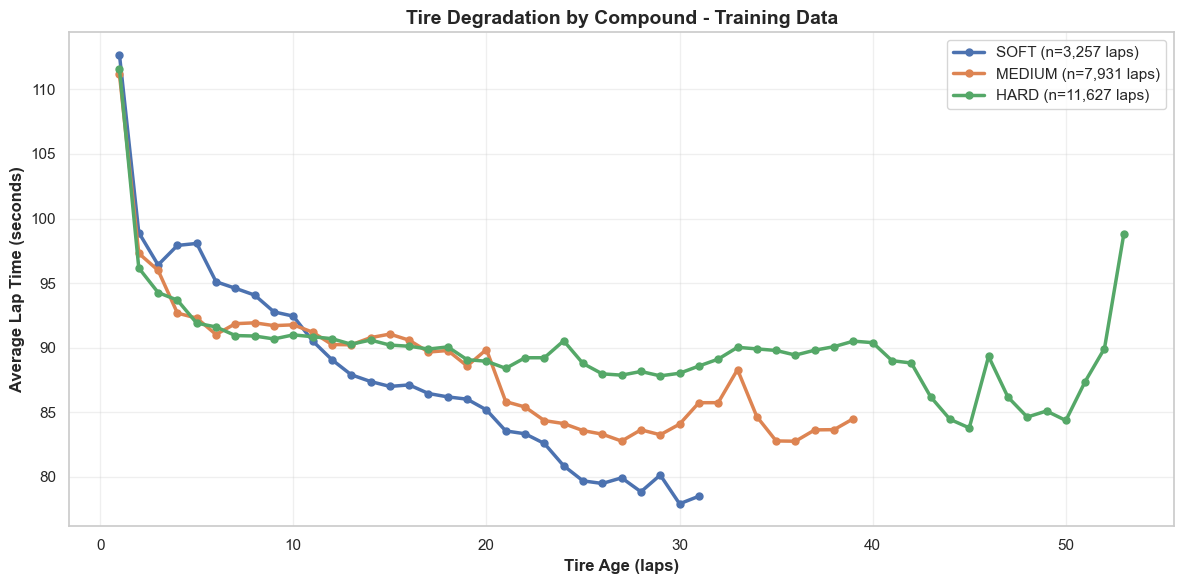

In [21]:
import matplotlib.pyplot as plt

print("=== TIRE DEGRADATION ANALYSIS ===\n")

# For each compound, show average lap time vs tire age
fig, ax = plt.subplots(figsize=(12, 6))

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    compound_data = df[df['compound'] == compound]
    
    # Group by tire age and calculate mean lap time
    degradation = compound_data.groupby('tyre_life')['lap_time'].agg(['mean', 'count'])
    
    # Only plot where we have enough data
    degradation = degradation[degradation['count'] >= 10]
    
    ax.plot(degradation.index, degradation['mean'], 
            marker='o', label=f'{compound} (n={len(compound_data):,} laps)', 
            linewidth=2.5, markersize=5)
    
    print(f"{compound}:")
    print(f"  Total laps: {len(compound_data):,}")
    print(f"  Max tire age: {compound_data['tyre_life'].max():.0f} laps")
    print(f"  Avg lap time: {compound_data['lap_time'].mean():.2f}s")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Tire Degradation by Compound - Training Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== MODEL PREDICTIONS: Tire Degradation (After Fix) ===

SOFT:
  Lap 1:  94.44s
  Lap 40: 95.53s
  Total degradation: +1.09s ✅ REALISTIC!
  Degradation per lap: +0.027s/lap

MEDIUM:
  Lap 1:  94.43s
  Lap 40: 95.59s
  Total degradation: +1.17s ✅ REALISTIC!
  Degradation per lap: +0.029s/lap

HARD:
  Lap 1:  94.42s
  Lap 40: 95.59s
  Total degradation: +1.18s ✅ REALISTIC!
  Degradation per lap: +0.029s/lap



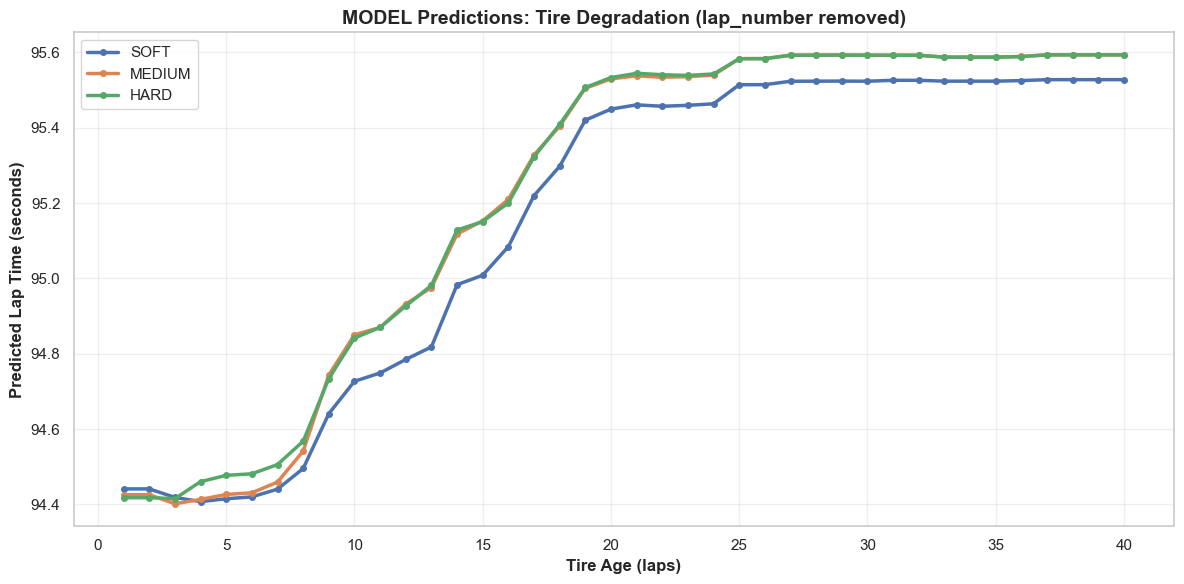

In [22]:
import matplotlib.pyplot as plt
print("=== MODEL PREDICTIONS: Tire Degradation (After Fix) ===\n")

fig, ax = plt.subplots(figsize=(12, 6))

# Simulate tire degradation for each compound
tire_ages = range(1, 41)  # Test up to 40 laps

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    predicted_times = []
    
    for age in tire_ages:
        pred = predict_tyre_laptime(
            gp_name="Bahrain Grand Prix",
            compound=compound,
            tyre_life=age,
            stint=1,
            fuel_load_pct=0.5,
            track_temp=36,
            air_temp=28,
            humidity=40,
            wind_speed=3.2,
            wind_dir=140,
            pressure=1006,
            driver=None
        )
        predicted_times.append(pred)
    
    ax.plot(tire_ages, predicted_times, marker='o', label=compound, 
            linewidth=2.5, markersize=4)
    
    # Print degradation rate
    degradation_total = predicted_times[-1] - predicted_times[0]
    degradation_rate = degradation_total / len(tire_ages)
    
    print(f"{compound}:")
    print(f"  Lap 1:  {predicted_times[0]:.2f}s")
    print(f"  Lap 40: {predicted_times[-1]:.2f}s")
    print(f"  Total degradation: {degradation_total:+.2f}s {'✅ REALISTIC!' if degradation_total > 0 else '❌ WRONG!'}")
    print(f"  Degradation per lap: {degradation_rate:+.3f}s/lap")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MODEL Predictions: Tire Degradation (lap_number removed)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Find which races show the MOST tire degradation
print("=== FINDING BEST RACE FOR STRATEGY DEMO ===\n")

race_degradation = []

for race in df['gp_name'].unique():
    race_data = df[df['gp_name'] == race]
    
    # For each compound, measure degradation
    for compound in ['SOFT', 'MEDIUM', 'HARD']:
        compound_data = race_data[race_data['compound'] == compound]
        
        if len(compound_data) < 50:  # Need enough data
            continue
        
        # Group by tire age
        deg = compound_data.groupby('tyre_life')['lap_time'].mean()
        
        if len(deg) < 10:  # Need enough tire ages
            continue
        
        # Calculate degradation: (lap 20 - lap 5)
        if 5 in deg.index and 20 in deg.index:
            degradation = deg[20] - deg[5]
            
            race_degradation.append({
                'race': race,
                'compound': compound,
                'deg_15_laps': degradation,
                'laps': len(compound_data)
            })

# Sort by degradation
deg_df = pd.DataFrame(race_degradation)
deg_df = deg_df.sort_values('deg_15_laps', ascending=False)

print("Top 15 Race-Compound Combinations with Most Degradation:\n")
print(deg_df.head(15).to_string(index=False))

print("\n\n=== BEST RACES FOR DEMO (Highest Avg Degradation) ===\n")
race_avg_deg = deg_df.groupby('race')['deg_15_laps'].agg(['mean', 'max', 'count'])
race_avg_deg = race_avg_deg.sort_values('mean', ascending=False)
print(race_avg_deg.head(10))

=== FINDING BEST RACE FOR STRATEGY DEMO ===

Top 15 Race-Compound Combinations with Most Degradation:

                    race compound  deg_15_laps  laps
    Singapore Grand Prix   MEDIUM    17.790390   414
       Monaco Grand Prix   MEDIUM     7.088556   364
    Singapore Grand Prix     HARD     3.165948   574
      Belgian Grand Prix   MEDIUM     3.018410   412
    Singapore Grand Prix     SOFT     2.068000    56
    Las Vegas Grand Prix   MEDIUM     1.802300   201
      Italian Grand Prix   MEDIUM     1.612947   430
        Qatar Grand Prix   MEDIUM     1.247114   550
     Japanese Grand Prix     HARD     0.966580   456
     Austrian Grand Prix     HARD     0.459641   734
    São Paulo Grand Prix   MEDIUM     0.423462   365
      Spanish Grand Prix   MEDIUM     0.366517   399
       Monaco Grand Prix     HARD     0.363733   657
United States Grand Prix     HARD     0.245476   425
    Abu Dhabi Grand Prix     HARD     0.239056   847


=== BEST RACES FOR DEMO (Highest Avg Degradatio

In [24]:
# ============================================
# FIND WHICH RACES HAVE MOST TIRE DEGRADATION
# ============================================
print("=== ANALYZING TIRE DEGRADATION BY RACE ===\n")

race_stats = []

for race in df['gp_name'].unique():
    race_data = df[df['gp_name'] == race]
    
    # Calculate degradation for each compound
    for compound in ['SOFT', 'MEDIUM', 'HARD']:
        compound_data = race_data[race_data['compound'] == compound]
        
        if len(compound_data) < 30:  # Need enough data
            continue
        
        # Measure degradation: compare fresh tires (lap 1-3) vs old (lap 15-20)
        fresh = compound_data[compound_data['tyre_life'] <= 3]['lap_time'].mean()
        old = compound_data[(compound_data['tyre_life'] >= 15) & 
                           (compound_data['tyre_life'] <= 20)]['lap_time'].mean()
        
        if pd.notna(fresh) and pd.notna(old):
            degradation = old - fresh
            
            race_stats.append({
                'race': race,
                'compound': compound,
                'degradation': degradation,
                'laps_data': len(compound_data)
            })

# Create DataFrame
stats_df = pd.DataFrame(race_stats)

# Find races with highest average degradation
race_avg_deg = stats_df.groupby('race').agg({
    'degradation': ['mean', 'max'],
    'laps_data': 'sum'
}).round(3)

race_avg_deg.columns = ['avg_degradation', 'max_degradation', 'total_laps']
race_avg_deg = race_avg_deg.sort_values('avg_degradation', ascending=False)

print("=== RACES RANKED BY TIRE DEGRADATION ===\n")
print("(Positive = tires degrade, Negative = tires improve)\n")
print(race_avg_deg.head(10))

print(f"\n✅ BEST RACE FOR DEMO: {race_avg_deg.index[0]}")
print(f"   Average degradation: {race_avg_deg.iloc[0]['avg_degradation']:.2f}s over 15 laps")


=== ANALYZING TIRE DEGRADATION BY RACE ===

=== RACES RANKED BY TIRE DEGRADATION ===

(Positive = tires degrade, Negative = tires improve)

                          avg_degradation  max_degradation  total_laps
race                                                                  
Monaco Grand Prix                  -0.861           -0.125        1021
Belgian Grand Prix                 -1.972           -1.383         784
Hungarian Grand Prix               -2.534            2.019        1232
Italian Grand Prix                 -3.712           -1.949         929
Miami Grand Prix                   -3.721           -2.710        1111
Abu Dhabi Grand Prix               -3.849           -1.229        1136
Spanish Grand Prix                 -4.919           -3.168        1292
United States Grand Prix           -5.152           -4.093         984
Bahrain Grand Prix                 -5.776           -4.414        1025
Canadian Grand Prix                -7.705            2.953        1283

✅ BEST 

=== MODEL PREDICTIONS: Tire Degradation (With Fuel Correction) ===

SOFT:
  Lap 1:  94.44s
  Lap 40: 95.53s
  Total degradation: +1.09s ✅ REALISTIC!
  Degradation per lap: +0.027s/lap

MEDIUM:
  Lap 1:  94.43s
  Lap 40: 95.59s
  Total degradation: +1.17s ✅ REALISTIC!
  Degradation per lap: +0.029s/lap

HARD:
  Lap 1:  94.42s
  Lap 40: 95.59s
  Total degradation: +1.18s ✅ REALISTIC!
  Degradation per lap: +0.029s/lap



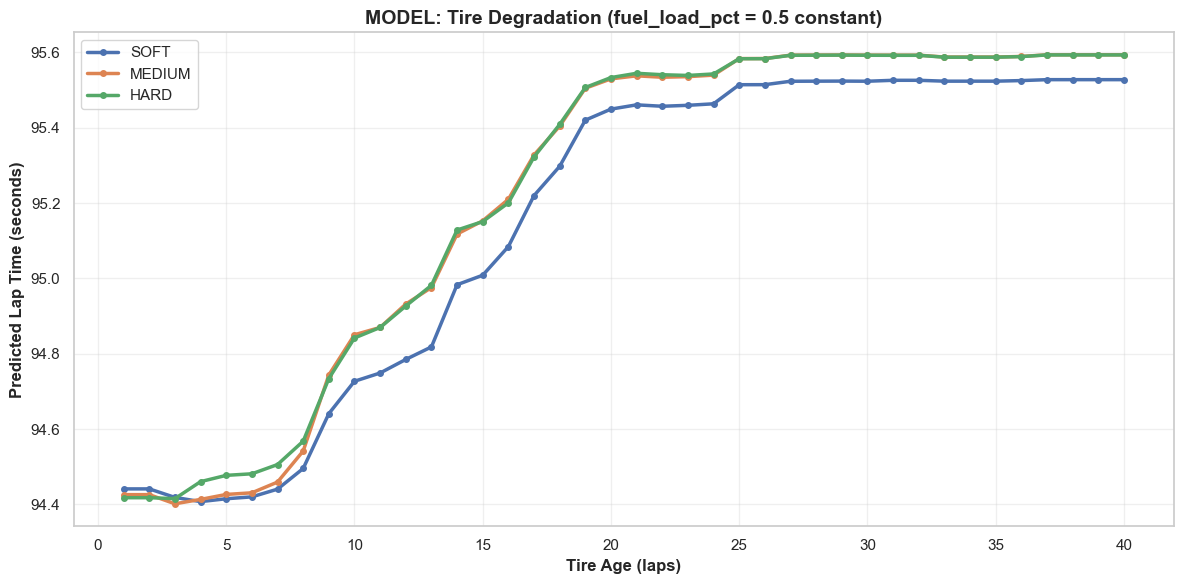

In [ ]:
print("=== MODEL PREDICTIONS: Tire Degradation (With Fuel Correction) ===\n")

fig, ax = plt.subplots(figsize=(12, 6))

# Simulate tire degradation for each compound
tire_ages = range(1, 41)  # Test up to 40 laps

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    predicted_times = []
    
    for age in tire_ages:
        # FIXED: Use constant fuel load to isolate tire degradation
        # Simulate mid-race conditions (50% fuel remaining)
        pred = predict_tyre_laptime(
            gp_name="Bahrain Grand Prix",
            compound=compound,
            tyre_life=age,
            stint=1,
            fuel_load_pct=0.5,  # ← ADDED: Constant fuel to isolate tire effect
            track_temp=36,
            air_temp=28,
            humidity=40,
            wind_speed=3.2,
            wind_dir=140,
            pressure=1006,
            driver=None
        )
        predicted_times.append(pred)
    
    ax.plot(tire_ages, predicted_times, marker='o', label=compound, 
            linewidth=2.5, markersize=4)
    
    # Print degradation rate
    degradation_total = predicted_times[-1] - predicted_times[0]
    degradation_rate = degradation_total / len(tire_ages)
    
    print(f"{compound}:")
    print(f"  Lap 1:  {predicted_times[0]:.2f}s")
    print(f"  Lap 40: {predicted_times[-1]:.2f}s")
    print(f"  Total degradation: {degradation_total:+.2f}s {'✅ REALISTIC!' if degradation_total > 0 else '❌ WRONG!'}")
    print(f"  Degradation per lap: {degradation_rate:+.3f}s/lap")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MODEL: Tire Degradation (fuel_load_pct = 0.5 constant)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
